This notebook is an introduction to how we can use YOLOv3 to process images

First, verify that all dependancies are satisfied:

In [2]:
!pip install opencv-python
!pip install matplotlib

In [1]:
import src.network as network
import src.file_helper as fh

In [2]:
weights = "yolov3.weights"
cfg = "yolov3.cfg"
classes = "coco.names"

image = "demo.jpg"

In [3]:
net = network.load(weights, cfg)

classes = network.prepare_classes(classes)

In [6]:
output_layers = network.extract_output_layers(net)

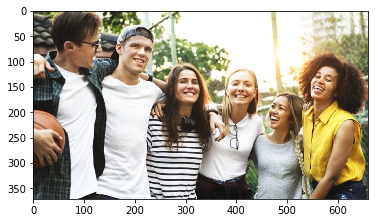

In [7]:
img = fh.load_image(image)

fh.show_image(img)

In [8]:
blob = network.image_to_blob(img)

In [9]:
outputs = network.forward(net, blob, output_layers)

In [10]:
network.process_result(img, outputs, classes)